# Lab 3: Clustering and Manifold Learning

#### Name:  Paul Trayers
#### Student ID:  8907021

## Introduction
### Objective

The aim is to demonstrate following;
- k-Means clustering algorithm along with Elbow and Silhouette techniques to select k.
- Use of manifold-learning techniques to project the clustered dataset into a 2D space and visualise as a scatterplot.
- Other clustering techniquues for comparison with k-Means.
- Analysis and interpretation of resulting clusters.

### Assumptions
- The data has been preprocessed containing only numerical attributes, however we will not assume it has been _optimally_ pre-processed for clustering algorithms.

## 1. Load Dataset

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn import preprocessing #needed for scaling attributes to the interval [0,1]
from sklearn import metrics #needed silhouette_score plot

In [46]:
df = pd.read_csv("./loans_train_prepared.csv")
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)
df.head()

(number of examples, number of attributes):  (614, 16)


Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0    0.000000         1.084523    1.058140              0.75               1   
1    0.333333         0.925883    1.047319              0.75               1   
2    0.000000         0.683858    0.635920              0.75               1   
3    0.000000         0.608992    1.002824              0.75               1   
4    0.000000         1.101869    1.115650              0.75               1   

   Gender_Male  Gender_nan  Married_Yes  Married_nan  Self_Employed_Yes  \
0            1           0            0            0                  0   
1            1           0            1            0                  0   
2            1           0            1            0                  1   
3            1           0            1            0                  0   
4            1           0            0            0                  0   

   Self_Employed_nan  Education_Not Graduate  Property_Area_Semiurban  \
0                  0                       0                        0   
1                  0                       0                        0   
2                  0                       0                        0   
3                  0                       1                        0   
4                  0                       0                        0   

   Property_Area_Urban  Loan_Status_Y  TotalIncome  
0                    1              1     0.841086  
1                    0              0     0.871711  
2                    1              1     0.385189  
3                    1              1     0.717012  
4                    1              1     0.860305

We can identify initially the following feature types in the data;
* Demographic: Dependents, Gender, Married, Self_Employed, Education_Not_Graduate, Property_Area
* Financial: Credit_History, ApplicantIncome, TotalIncome
* Loans: Loan_Status, LoanAmount, Loan_Amount_Term

### 1.2 Helper Functions

The function `clustering_scatterplot()` creates the 2D scatter plot of the clustered dataset.

In [47]:
cluster_colors = np.array(['orange', 'blue', 'lime', 'red', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot

def clustering_scatterplot(points, labels, centers, title):
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=cluster_colors[i%cluster_colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

# Task 2: k-Means

## 2. Data Treatment - Re-scaling, Encoding, Feature selection
Here we re-scale the values in each column to the interval $[0,1]$ with MinMaxScaler. Please note that if your dataset is already prepared for ML there is no need to rescale it again. See https://scikit-learn.org/stable/modules/preprocessing.html for alternative rescaling techniques. In your work on this exercise experiment with other rescaling techniques to see if they lead to a more insightful clustering.

### 2.1 Re-scaling
* Visually data appears as if it might be normalised being approximately within the range [0, 1] or same order of magnitude, however we do not know for certain. Therefore, we will check the range is indeed [0, 1], whether the means are zero and whether standard deviation is close to 1.

In [48]:
df.describe()

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  \
count  614.000000       614.000000  614.000000        614.000000   
mean     0.248100         0.916588    1.076222          0.713355   
std      0.336541         0.412366    0.338744          0.134226   
min      0.000000         0.004634    0.005026          0.025000   
25%      0.000000         0.662440    0.883668          0.750000   
50%      0.000000         0.815365    1.047319          0.750000   
75%      0.333333         1.078246    1.229571          0.750000   
max      1.000000         3.357480    2.461145          1.000000   

       Credit_History  Gender_Male  Gender_nan  Married_Yes  Married_nan  \
count      614.000000   614.000000  614.000000   614.000000   614.000000   
mean         0.855049     0.796417    0.021173     0.648208     0.004886   
std          0.352339     0.402991    0.144077     0.477919     0.069786   
min          0.000000     0.000000    0.000000     0.000000     0.000000   
25%          1.000000     1.000000    0.000000     0.000000     0.000000   
50%          1.000000     1.000000    0.000000     1.000000     0.000000   
75%          1.000000     1.000000    0.000000     1.000000     0.000000   
max          1.000000     1.000000    1.000000     1.000000     1.000000   

       Self_Employed_Yes  Self_Employed_nan  Education_Not Graduate  \
count         614.000000         614.000000              614.000000   
mean            0.133550           0.052117                0.218241   
std             0.340446           0.222445                0.413389   
min             0.000000           0.000000                0.000000   
25%             0.000000           0.000000                0.000000   
50%             0.000000           0.000000                0.000000   
75%             0.000000           0.000000                0.000000   
max             1.000000           1.000000                1.000000   

       Property_Area_Semiurban  Property_Area_Urban  Loan_Status_Y  \
count               614.000000           614.000000     614.000000   
mean                  0.379479             0.328990       0.687296   
std                   0.485653             0.470229       0.463973   
min                   0.000000             0.000000       0.000000   
25%                   0.000000             0.000000       0.000000   
50%                   0.000000             0.000000       1.000000   
75%                   1.000000             1.000000       1.000000   
max                   1.000000             1.000000       1.000000   

       TotalIncome  
count   614.000000  
mean      0.862686  
std       0.428068  
min       0.005599  
25%       0.597383  
50%       0.783902  
75%       1.035796  
max       3.207353

In [49]:
df_original = df.copy(deep=True)  # create a deep copy of the DataFrame

# data already appears to be re-scaled. Should we re-scale it again? Probably not. BUT it appears to 
# significantly improve all subsequent plots in terms of helping provide dense, more clearly separated clusters.

# List of columns to scale
columns_to_scale = ['ApplicantIncome', 'LoanAmount', 'TotalIncome']

minmax_scaler = preprocessing.MinMaxScaler()
#data = minmax_scaler.fit_transform(data)

# Scale the specified columns using MinMaxScaler and assign the results back to the original DataFrame
df[columns_to_scale] = minmax_scaler.fit_transform(df[columns_to_scale])
df.describe()

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  \
count  614.000000       614.000000  614.000000        614.000000   
mean     0.248100         0.271994    0.436134          0.713355   
std      0.336541         0.122990    0.137918          0.134226   
min      0.000000         0.000000    0.000000          0.025000   
25%      0.000000         0.196194    0.357736          0.750000   
50%      0.000000         0.241804    0.424366          0.750000   
75%      0.333333         0.320209    0.498569          0.750000   
max      1.000000         1.000000    1.000000          1.000000   

       Credit_History  Gender_Male  Gender_nan  Married_Yes  Married_nan  \
count      614.000000   614.000000  614.000000   614.000000   614.000000   
mean         0.855049     0.796417    0.021173     0.648208     0.004886   
std          0.352339     0.402991    0.144077     0.477919     0.069786   
min          0.000000     0.000000    0.000000     0.000000     0.000000   
25%          1.000000     1.000000    0.000000     0.000000     0.000000   
50%          1.000000     1.000000    0.000000     1.000000     0.000000   
75%          1.000000     1.000000    0.000000     1.000000     0.000000   
max          1.000000     1.000000    1.000000     1.000000     1.000000   

       Self_Employed_Yes  Self_Employed_nan  Education_Not Graduate  \
count         614.000000         614.000000              614.000000   
mean            0.133550           0.052117                0.218241   
std             0.340446           0.222445                0.413389   
min             0.000000           0.000000                0.000000   
25%             0.000000           0.000000                0.000000   
50%             0.000000           0.000000                0.000000   
75%             0.000000           0.000000                0.000000   
max             1.000000           1.000000                1.000000   

       Property_Area_Semiurban  Property_Area_Urban  Loan_Status_Y  \
count               614.000000           614.000000     614.000000   
mean                  0.379479             0.328990       0.687296   
std                   0.485653             0.470229       0.463973   
min                   0.000000             0.000000       0.000000   
25%                   0.000000             0.000000       0.000000   
50%                   0.000000             0.000000       1.000000   
75%                   1.000000             1.000000       1.000000   
max                   1.000000             1.000000       1.000000   

       TotalIncome  
count   614.000000  
mean      0.267693  
std       0.133698  
min       0.000000  
25%       0.184831  
50%       0.243086  
75%       0.321760  
max       1.000000

#### 2.1.1 Comment
We can observe that means are generally not close to zero, nor are standard deviations close to 1.  We can consider applying MinMaxScaler however we should not generally apply multiple re-scaling. However, in this case we find it appears to significantly improve subsequent plots in terms of helping provide denser, more clearly separated clusters, therefore are using it but remaining aware of the risks of distortion of the data.

We can now observe all ranges between [0, 1]

In [50]:
df.describe()

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  \
count  614.000000       614.000000  614.000000        614.000000   
mean     0.248100         0.271994    0.436134          0.713355   
std      0.336541         0.122990    0.137918          0.134226   
min      0.000000         0.000000    0.000000          0.025000   
25%      0.000000         0.196194    0.357736          0.750000   
50%      0.000000         0.241804    0.424366          0.750000   
75%      0.333333         0.320209    0.498569          0.750000   
max      1.000000         1.000000    1.000000          1.000000   

       Credit_History  Gender_Male  Gender_nan  Married_Yes  Married_nan  \
count      614.000000   614.000000  614.000000   614.000000   614.000000   
mean         0.855049     0.796417    0.021173     0.648208     0.004886   
std          0.352339     0.402991    0.144077     0.477919     0.069786   
min          0.000000     0.000000    0.000000     0.000000     0.000000   
25%          1.000000     1.000000    0.000000     0.000000     0.000000   
50%          1.000000     1.000000    0.000000     1.000000     0.000000   
75%          1.000000     1.000000    0.000000     1.000000     0.000000   
max          1.000000     1.000000    1.000000     1.000000     1.000000   

       Self_Employed_Yes  Self_Employed_nan  Education_Not Graduate  \
count         614.000000         614.000000              614.000000   
mean            0.133550           0.052117                0.218241   
std             0.340446           0.222445                0.413389   
min             0.000000           0.000000                0.000000   
25%             0.000000           0.000000                0.000000   
50%             0.000000           0.000000                0.000000   
75%             0.000000           0.000000                0.000000   
max             1.000000           1.000000                1.000000   

       Property_Area_Semiurban  Property_Area_Urban  Loan_Status_Y  \
count               614.000000           614.000000     614.000000   
mean                  0.379479             0.328990       0.687296   
std                   0.485653             0.470229       0.463973   
min                   0.000000             0.000000       0.000000   
25%                   0.000000             0.000000       0.000000   
50%                   0.000000             0.000000       1.000000   
75%                   1.000000             1.000000       1.000000   
max                   1.000000             1.000000       1.000000   

       TotalIncome  
count   614.000000  
mean      0.267693  
std       0.133698  
min       0.000000  
25%       0.184831  
50%       0.243086  
75%       0.321760  
max       1.000000

### 2.2 Re-encoding

We can also see that one-hot encoding is increasing the dimensionality of the dataset which could be computationally expensive for clustering algorithms to process. This may not be the best choice for clustering if there is a large number of categories, as it can lead to sparsity in the resulting data. In such cases, other encoding techniques, such as binary encoding or ordinal encoding, may be more suitable allowing us to consolidate multiple fields..

#### 2.2.1 Check `NaNs`
Check how many `Nans` in each of the `_nan` columns:


In [51]:
# List of columns for which you want to count the number of 1s
columns_to_check = ['Gender_nan', 'Married_nan', 'Self_Employed_nan']

# Count the number of 1s for each specified column
count_ones = df[columns_to_check].apply(lambda x: (x == 1).sum())
print(count_ones)

Gender_nan           13
Married_nan           3
Self_Employed_nan    32
dtype: int64


#### 2.2.2 Replace NaNs
Here we replace the values in other columns with their mean values for those records where the specified NaN columns are 1, then drop the NaN columns:

In [52]:
# List of columns for which you want to replace values with their mean values when NaN columns are 1
columns_to_replace = ['Gender_Male', 'Married_Yes', 'Self_Employed_Yes']
nan_columns = ['Gender_nan', 'Married_nan', 'Self_Employed_nan']

# Replace the values in the specified columns with their mean values when NaN columns are 1
for col, nan_col in zip(columns_to_replace, nan_columns):
    mean_value = df.loc[df[nan_col] == 0, col].mode().iloc[0]
    df.loc[df[nan_col] == 1, col] = mean_value

# Drop the NaN columns
df = df.drop(columns=nan_columns)
df.describe()  # Print the updated DataFrame

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  \
count  614.000000       614.000000  614.000000        614.000000   
mean     0.248100         0.271994    0.436134          0.713355   
std      0.336541         0.122990    0.137918          0.134226   
min      0.000000         0.000000    0.000000          0.025000   
25%      0.000000         0.196194    0.357736          0.750000   
50%      0.000000         0.241804    0.424366          0.750000   
75%      0.333333         0.320209    0.498569          0.750000   
max      1.000000         1.000000    1.000000          1.000000   

       Credit_History  Gender_Male  Married_Yes  Self_Employed_Yes  \
count      614.000000   614.000000   614.000000         614.000000   
mean         0.855049     0.817590     0.653094           0.133550   
std          0.352339     0.386497     0.476373           0.340446   
min          0.000000     0.000000     0.000000           0.000000   
25%          1.000000     1.000000     0.000000           0.000000   
50%          1.000000     1.000000     1.000000           0.000000   
75%          1.000000     1.000000     1.000000           0.000000   
max          1.000000     1.000000     1.000000           1.000000   

       Education_Not Graduate  Property_Area_Semiurban  Property_Area_Urban  \
count              614.000000               614.000000           614.000000   
mean                 0.218241                 0.379479             0.328990   
std                  0.413389                 0.485653             0.470229   
min                  0.000000                 0.000000             0.000000   
25%                  0.000000                 0.000000             0.000000   
50%                  0.000000                 0.000000             0.000000   
75%                  0.000000                 1.000000             1.000000   
max                  1.000000                 1.000000             1.000000   

       Loan_Status_Y  TotalIncome  
count     614.000000   614.000000  
mean        0.687296     0.267693  
std         0.463973     0.133698  
min         0.000000     0.000000  
25%         0.000000     0.184831  
50%         1.000000     0.243086  
75%         1.000000     0.321760  
max         1.000000     1.000000

### 2.3 Feature Selection

#### 2.3.1 Domain Decisions
Decision taken to drop following fields;
* Dropping `ApplicantIncome` as it is already represented in `TotalIncome` and we assume this as a sufficient measure of income for this case;
* Dropping `Loan_Status_Y` on the assumption that it more likely refers to status of a current loan application / approval rather than whether a loan is currently held.

In [53]:
columns_to_drop = ['ApplicantIncome', 'Loan_Status_Y']

# Drop the NaN columns
df = df.drop(columns=columns_to_drop)

#### 2.3.2 Feature Importance: Chi-Squared Test
We calculate feature importance scores using Chi-Squared test - a statistical test that measures the dependence between two categorical variables with high Chi-Squared value indicating the feature has a strong relationship with the target variable in this case `Loan_Status_Y`. Using the Chi-Squared test to select important categorical features:

In [54]:
df.head()

Dependents  LoanAmount  Loan_Amount_Term  Credit_History  Gender_Male  \
0    0.000000    0.428772              0.75               1            1   
1    0.333333    0.424366              0.75               1            1   
2    0.000000    0.256866              0.75               1            1   
3    0.000000    0.406250              0.75               1            1   
4    0.000000    0.452187              0.75               1            1   

   Married_Yes  Self_Employed_Yes  Education_Not Graduate  \
0            0                  0                       0   
1            1                  0                       0   
2            1                  1                       0   
3            1                  0                       1   
4            0                  0                       0   

   Property_Area_Semiurban  Property_Area_Urban  TotalIncome  
0                        0                    1     0.260947  
1                        0                    0     0.270512  
2                        0                    1     0.118557  
3                        0                    1     0.222195  
4                        0                    1     0.266949

In [55]:
from sklearn.feature_selection import SelectKBest, chi2

categorical_columns = ['Gender_Male', 'Married_Yes', 'Self_Employed_Yes', 'Education_Not Graduate', 'Property_Area_Semiurban', 'Property_Area_Urban']

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Separate features and target
#X = df_encoded.drop('Loan_Status_Y', axis=1)
X = df_encoded
y = df_original['Loan_Status_Y']

# Select top 2 features using the Chi-Squared test
selector = SelectKBest(chi2, k=3)
selector.fit(X, y)

# Get the selected feature names
selected_features = X.columns[selector.get_support()]

print("Selected features:", selected_features)

Selected features: Index(['Credit_History', 'Property_Area_Semiurban_0',
       'Property_Area_Semiurban_1'],
      dtype='object')


In [56]:
columns_to_drop = ['Gender_Male', 'Married_Yes', 'Self_Employed_Yes','Education_Not Graduate', 'Property_Area_Urban']

# Drop the less significant columns
#df = df.drop(columns=columns_to_drop)

In [57]:
df.describe()

Dependents  LoanAmount  Loan_Amount_Term  Credit_History  Gender_Male  \
count  614.000000  614.000000        614.000000      614.000000   614.000000   
mean     0.248100    0.436134          0.713355        0.855049     0.817590   
std      0.336541    0.137918          0.134226        0.352339     0.386497   
min      0.000000    0.000000          0.025000        0.000000     0.000000   
25%      0.000000    0.357736          0.750000        1.000000     1.000000   
50%      0.000000    0.424366          0.750000        1.000000     1.000000   
75%      0.333333    0.498569          0.750000        1.000000     1.000000   
max      1.000000    1.000000          1.000000        1.000000     1.000000   

       Married_Yes  Self_Employed_Yes  Education_Not Graduate  \
count   614.000000         614.000000              614.000000   
mean      0.653094           0.133550                0.218241   
std       0.476373           0.340446                0.413389   
min       0.000000           0.000000                0.000000   
25%       0.000000           0.000000                0.000000   
50%       1.000000           0.000000                0.000000   
75%       1.000000           0.000000                0.000000   
max       1.000000           1.000000                1.000000   

       Property_Area_Semiurban  Property_Area_Urban  TotalIncome  
count               614.000000           614.000000   614.000000  
mean                  0.379479             0.328990     0.267693  
std                   0.485653             0.470229     0.133698  
min                   0.000000             0.000000     0.000000  
25%                   0.000000             0.000000     0.184831  
50%                   0.000000             0.000000     0.243086  
75%                   1.000000             1.000000     0.321760  
max                   1.000000             1.000000     1.000000

### 2.4 Outliers
#### 2.4.1 Check outliers
This will also help remove outliers visible from the silhouette fingers plot.

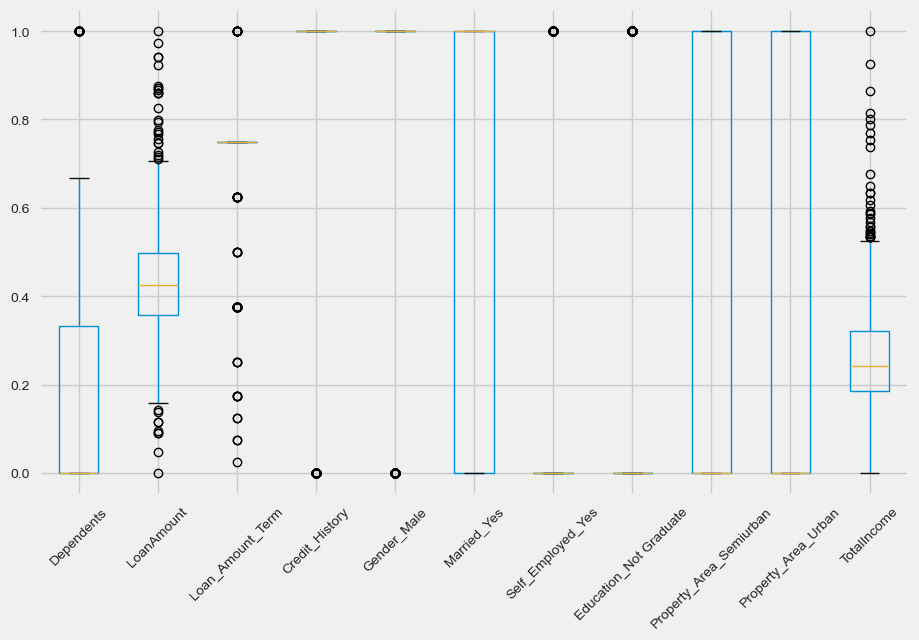

In [58]:
plt.figure(figsize=(10, 6)) # set figure size
ax = df.boxplot()
plt.xticks(rotation=45) # rotate x-labels
plt.show()

### 2.4.2 Remove outliers

First we identify the columns with outliers. Then, we calculate the IQR range for each column using quantile(). Finally, we remove any rows that contain outliers in either column by using the any() method to check if any of the columns fall outside of the IQR range, and using the ~ operator to invert the resulting boolean mask.

In [59]:
# define the IQR range
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# remove the outliers
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

We will include Dependent as there appears to be only one outlier but omit `Loan_Amount_Term` on the basis that it appears to be a categorical field. 

In [60]:
# define upper and lower bounds for each column
# cols = ['Dependents', 'ApplicantIncome', 'TotalIncome',]
cols = ['Dependents', 'TotalIncome',]
bounds = {}
for col in cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    bounds[col] = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)

# remove outliers from selected columns
#for col in cols:
#    df = df[(df[col] >= bounds[col][0]) & (df[col] <= bounds[col][1])]

Shows results of removing outliers...

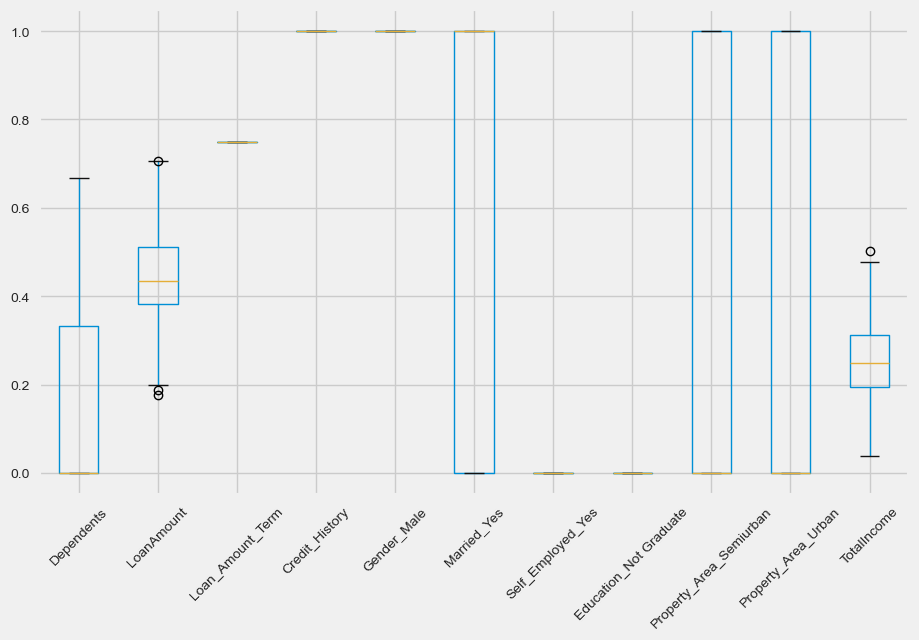

In [61]:
# Show outliers
plt.figure(figsize=(10, 6)) # set figure size
ax = df.boxplot()
plt.xticks(rotation=45) # rotate x-labels
plt.show()

## 3. K-Means Clustering
### 3.1 Finding k: Elbow Method

Fitting the KMeans clustering algorithm for different values of k (from 1 to 200) computing the within-cluster sum of squares (WCSS) for each value...

In [62]:
# fit k-means clustering for different values of k
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 12):
    kmeans = KMeans(n_clusters=i,   
                    # number of clusters to create. In the example, we are trying values from 1 to 200 to see which gives the best clustering result.
                    init='k-means++', # initialization method for the centroids. In this case, we are using the "k-means++" algorithm, which tries to choose initial centroids that are distant from each other.
                    max_iter=300,  # maximum number of iterations to run the algorithm for each value of n_clusters. If the algorithm does not converge within this number of iterations, it stops.
                    n_init=10,    # number of times to run the algorithm with different random initializations. Since the algorithm can converge to different solutions depending on the initial conditions, running it multiple times helps to find a good solution.
                    random_state=42)  # random seed used to initialize the random number generator. By setting this value to a fixed number to ensure that the results are reproducible.
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)  # appends value of WCSS for current value of n_clusters to wcss list.
#print(len(wcss))
#print(wcss)

The WCSS measures how close the data points within each cluster are to the centroid of the cluster by the sum of the squared distances between each data point and the centroid of its cluster. In the context of KMeans clustering, the WCSS is minimized during the clustering process, as the algorithm tries to find centroids that minimize the sum of squared distances.  Plotting the WCSS as a function of the number of clusters we hope to see an elbow shape, where the WCSS decreases rapidly for small values of k and starts to level off for larger values of k. The optimal number of clusters will be where the elbow is located..

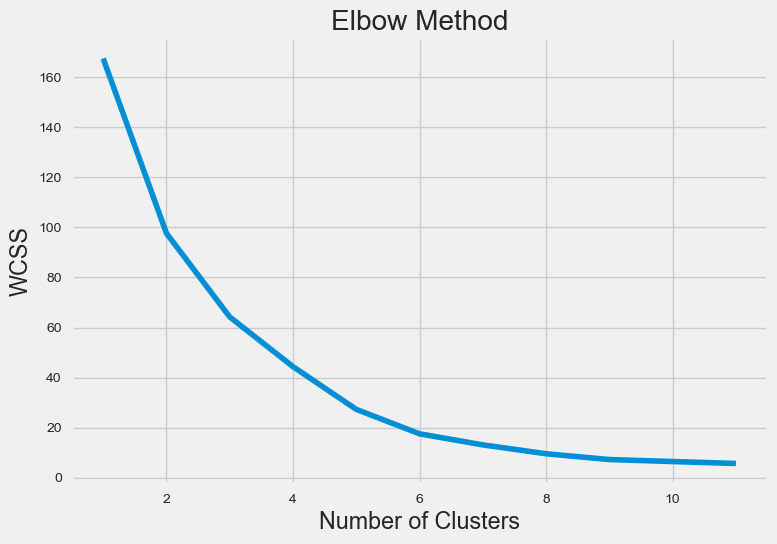

In [63]:
# plot the results
plt.plot(range(1, 12), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

#### 3.1.1 Comment - Basic Elbow interpretation

We visually inspect the plot and look for the point where the rate of decrease in WCSS slows down. This point should indicate the optimal number of clusters for the dataset.

Since there is no clearly identifiable point where the WCSS flattens out but is rather a continuous flattening, so there is no obvious optimal value of ‘K’ from the elbow method.  We can perhaps identify some "knee" in the curve where the rate of decrease in WCSS slows down around k=150, which indicates that adding more clusters is not providing a significant improvement in clustering performance. We will use a library function to calculate..

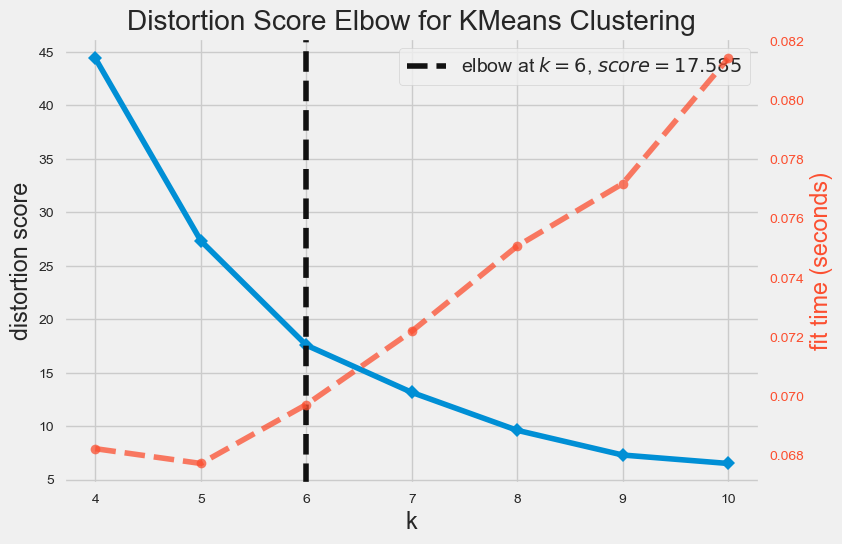

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [64]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42, n_init=10)  # repeatable results
visualizer = KElbowVisualizer(model, k=(4,11))

# Fit the data to the visualizer
visualizer.fit(df)

# Visualize the elbow plot
visualizer.show()

#### 3.1.1 Comment - Why Silhouette?

Since the elbow is not obvious, we also use the Silhouette method to help choose k...

Here we will use the silhouette method to determine the optimal number of clusters for a given dataset. The silhouette score measures how similar an object is to its own cluster compared to other clusters. A score of 1 indicates that the object is well-matched to its own cluster, while a score of -1 indicates that it is poorly matched to its own cluster and would be better off in a different cluster.

We start by looping over a range of values for n_clusters (from 2 to 10) and fitting a KMeans clustering model to the scaled data for each value of n_clusters. We then use the silhouette_score function from sklearn.metrics to compute the average silhouette score for the resulting clustering solution.

In [65]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Determine the optimal number of clusters using the silhouette method
silhouette_scores = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

In [66]:
#print(cluster_labels)
print(silhouette_scores)

[0.41876609357785916, 0.47707768993924987, 0.5302399528207993, 0.6234083398850299, 0.6864798504742813, 0.6747287533835974, 0.657439105176114, 0.6499622029620032]


### 3.2 Silhouette Plot - Basic

Here, we plot the silhouette scores against the number of clusters to visualize how the scores change as the number of clusters increases. We are looking for a peak in the silhouette scores, which indicates the optimal number of clusters for the given dataset.

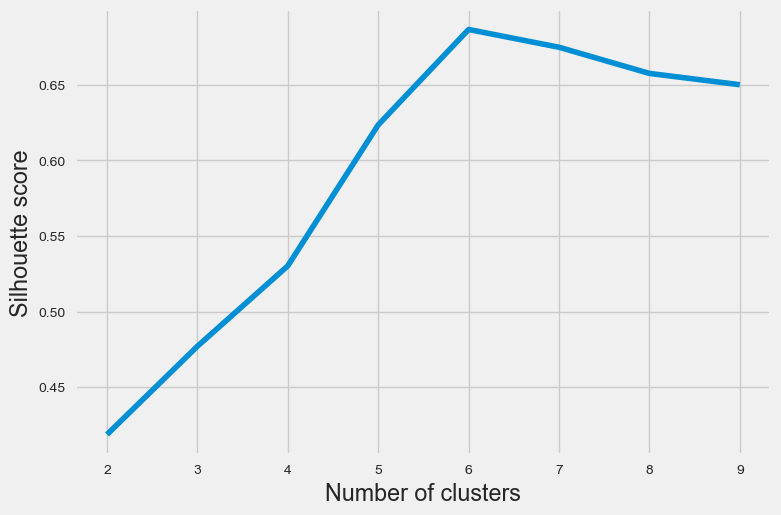

In [67]:
# Plot the silhouette scores for different number of clusters
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [68]:
optimal_n_clusters = np.argmax(silhouette_scores) + 2
print('Optimal number of clusters:', optimal_n_clusters)

Optimal number of clusters: 6


#### Comment - Why 'Fingers' Plot?
With the silhouette method, we have found an optimal number of clusters of 6 which concurs with our finding from the Elbow method. Since represents the highest average value across the invidual clusters for k, we can gain more insight by analysing the distribution of values across the clusters for each k.

Since because of the number of feature the dataset is of higher dimension than is possible to visualize, we will also add here alongside each finders plot a PCA transformation of the dataset identifying the clusters and centres. This will give us a sense of how well separated the clusters are (in terms of their different variances)

### 3.3 Silhouette Analysis - Fingers Plot

For n_clusters = 2 The average silhouette_score is : 0.41876609357785916
For n_clusters = 3 The average silhouette_score is : 0.47707768993924987
For n_clusters = 4 The average silhouette_score is : 0.5302399528207993
For n_clusters = 5 The average silhouette_score is : 0.6234083398850299
For n_clusters = 6 The average silhouette_score is : 0.6864798504742813
For n_clusters = 7 The average silhouette_score is : 0.6747287533835974
For n_clusters = 8 The average silhouette_score is : 0.657439105176114
For n_clusters = 9 The average silhouette_score is : 0.6499622029620032


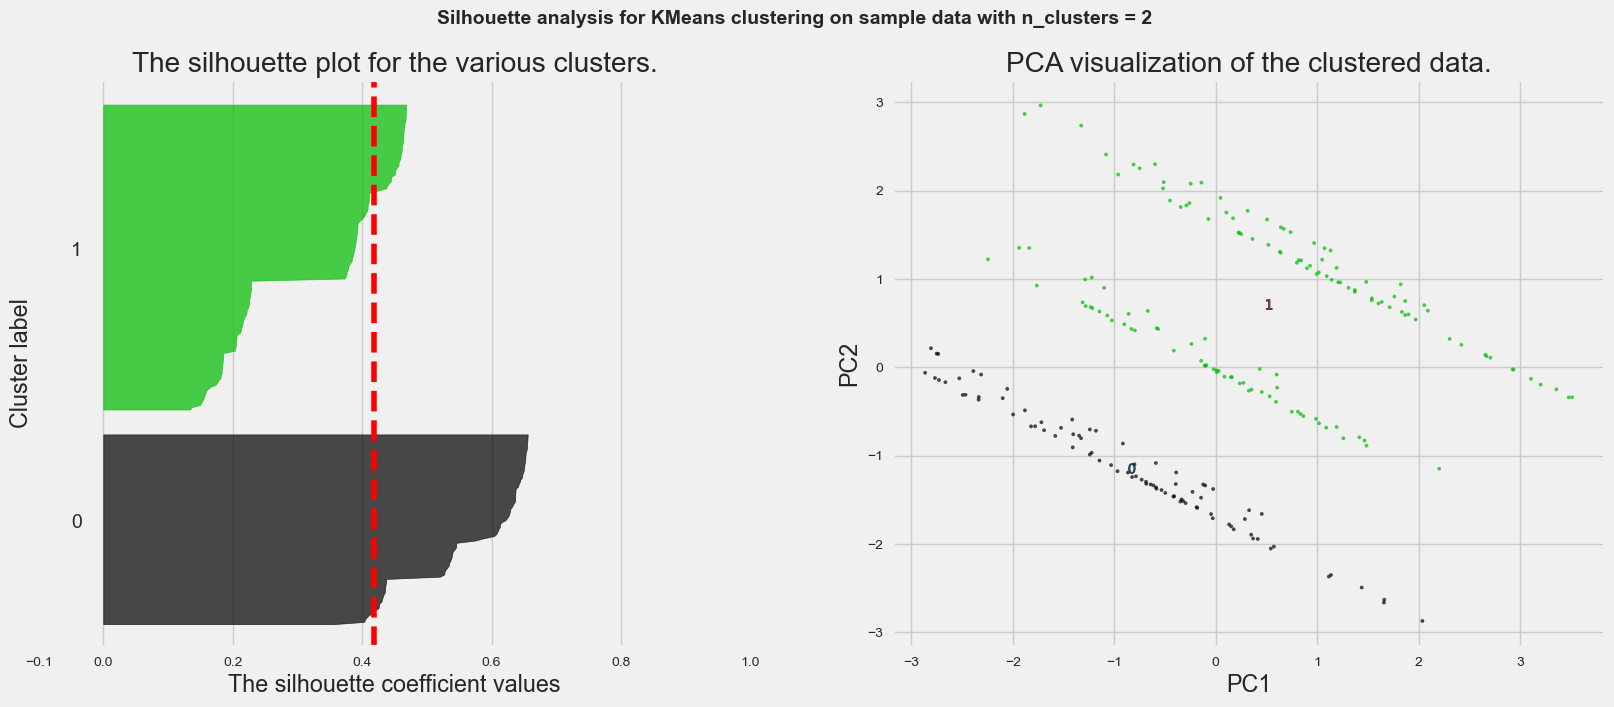

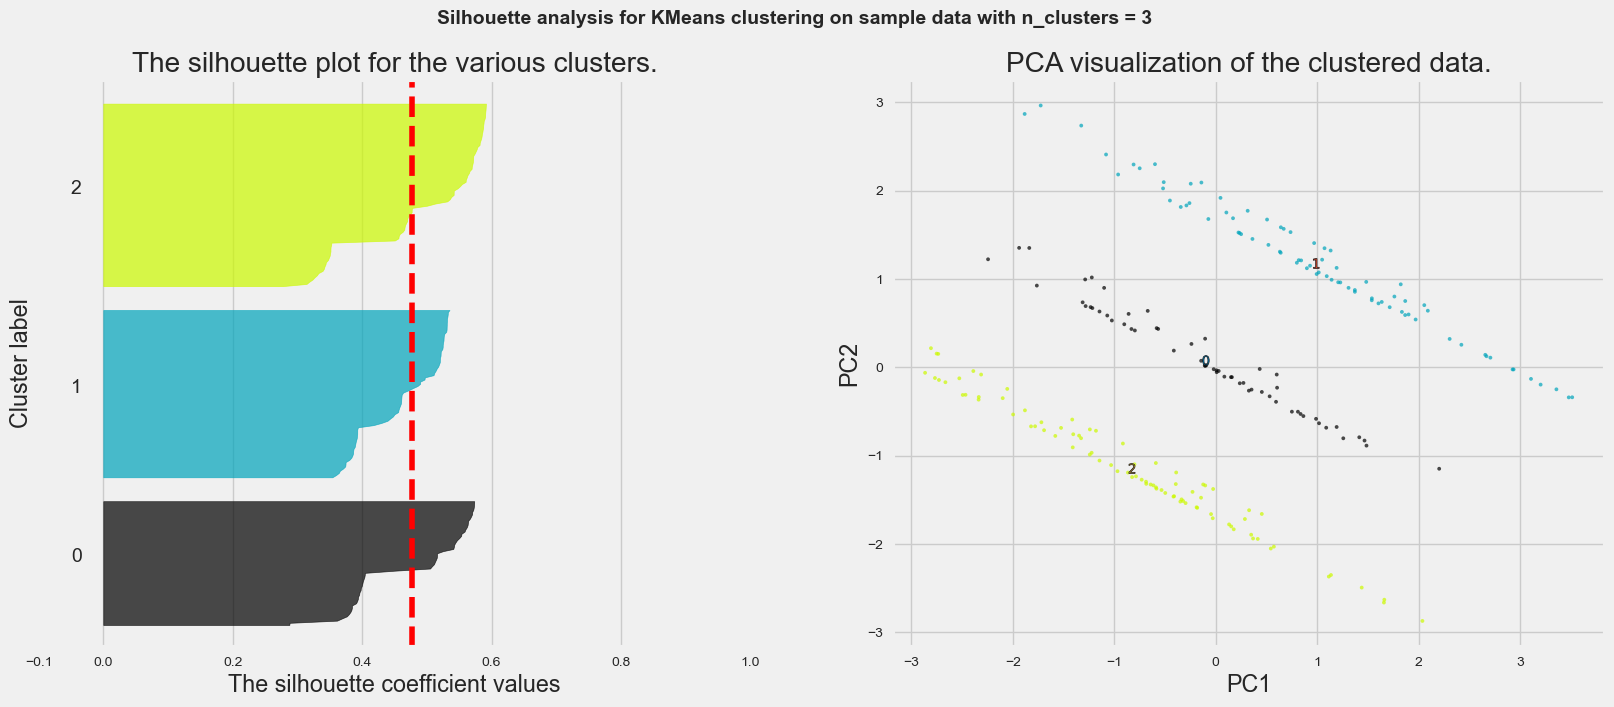

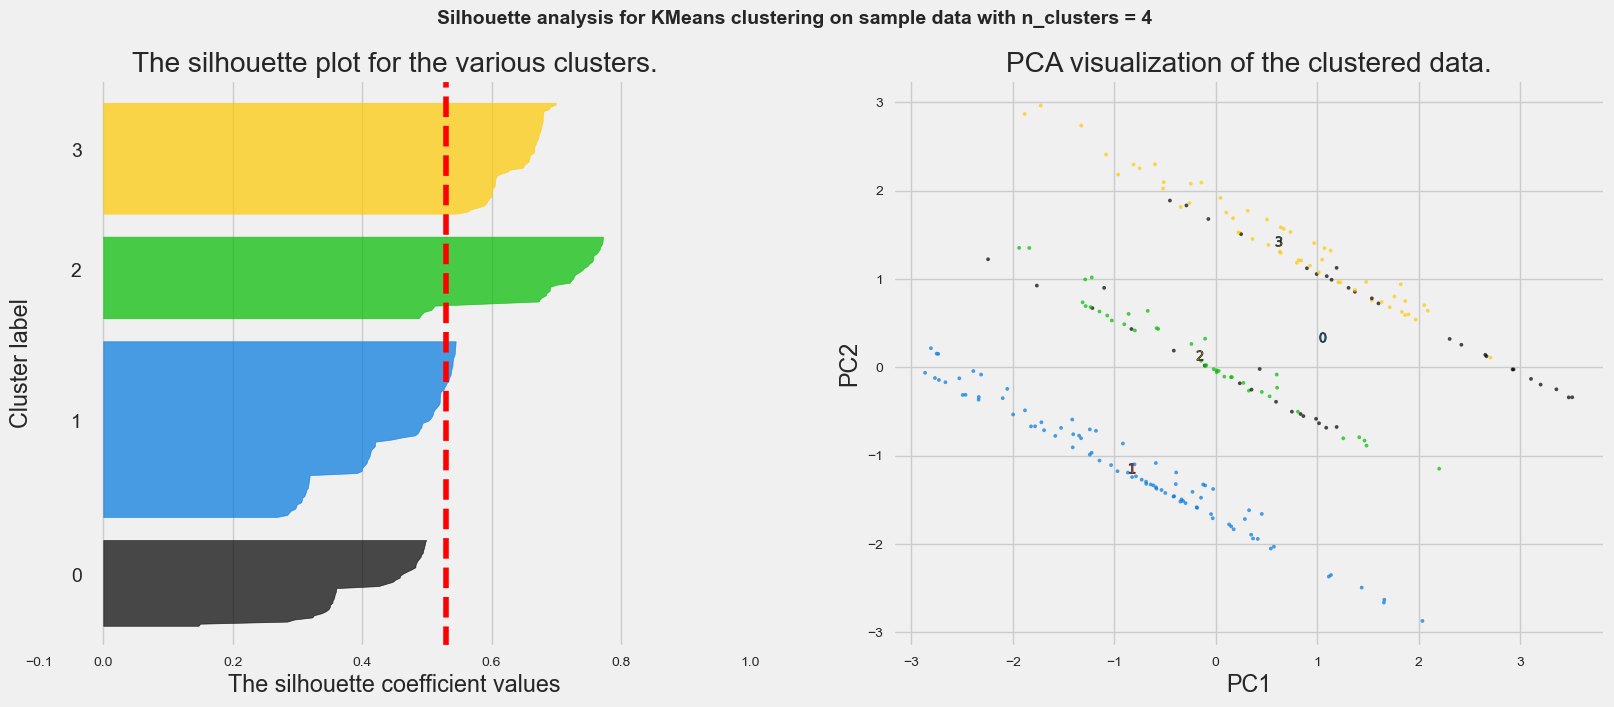

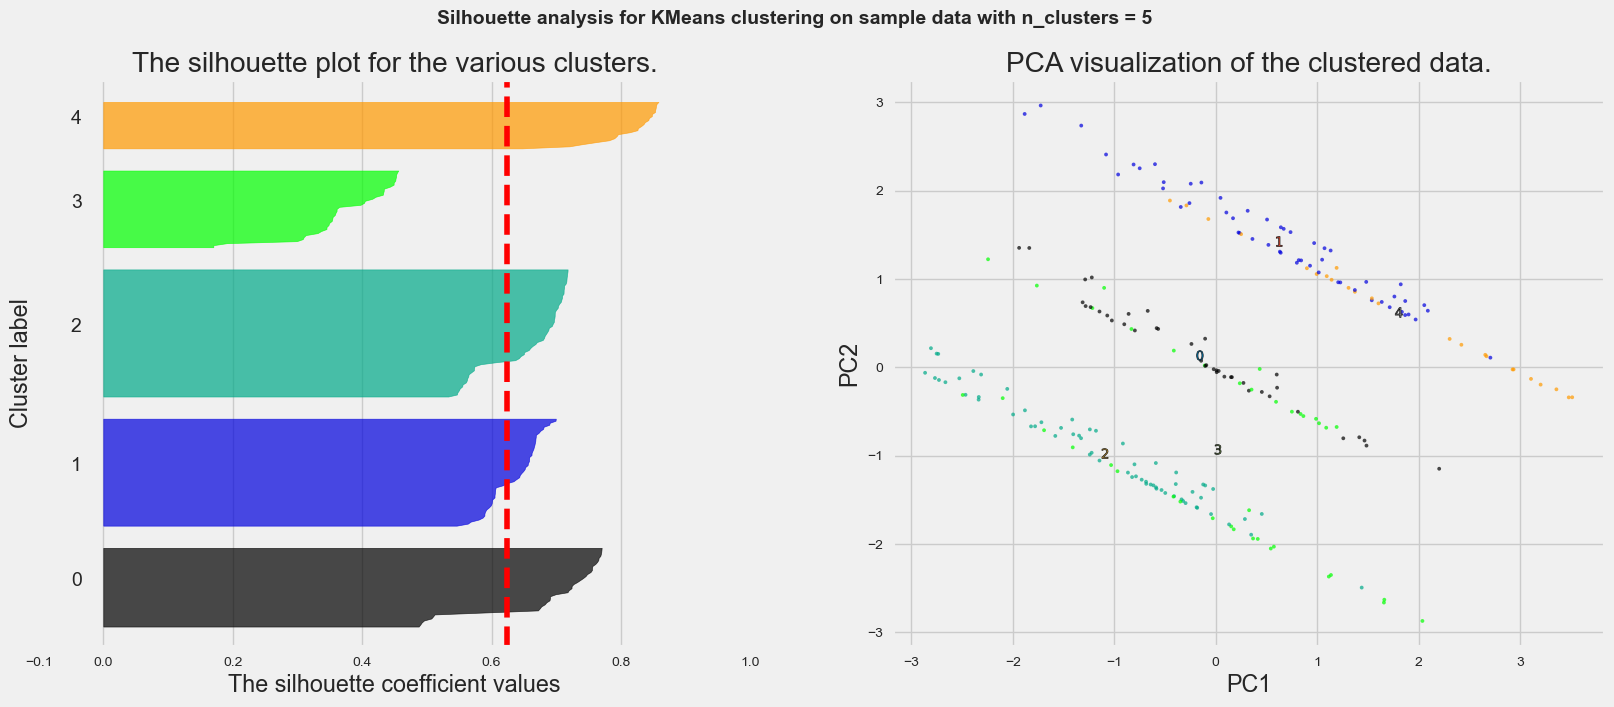

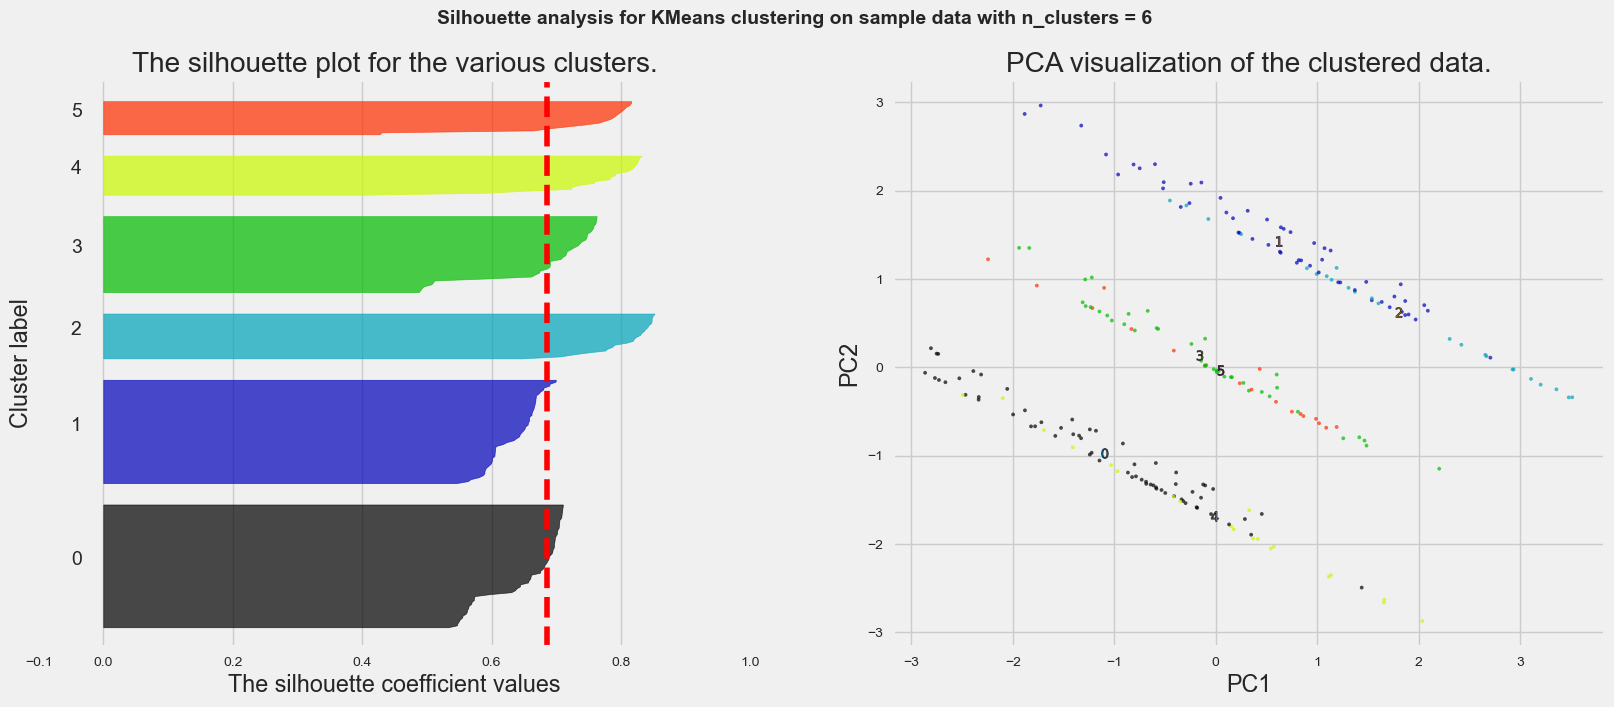

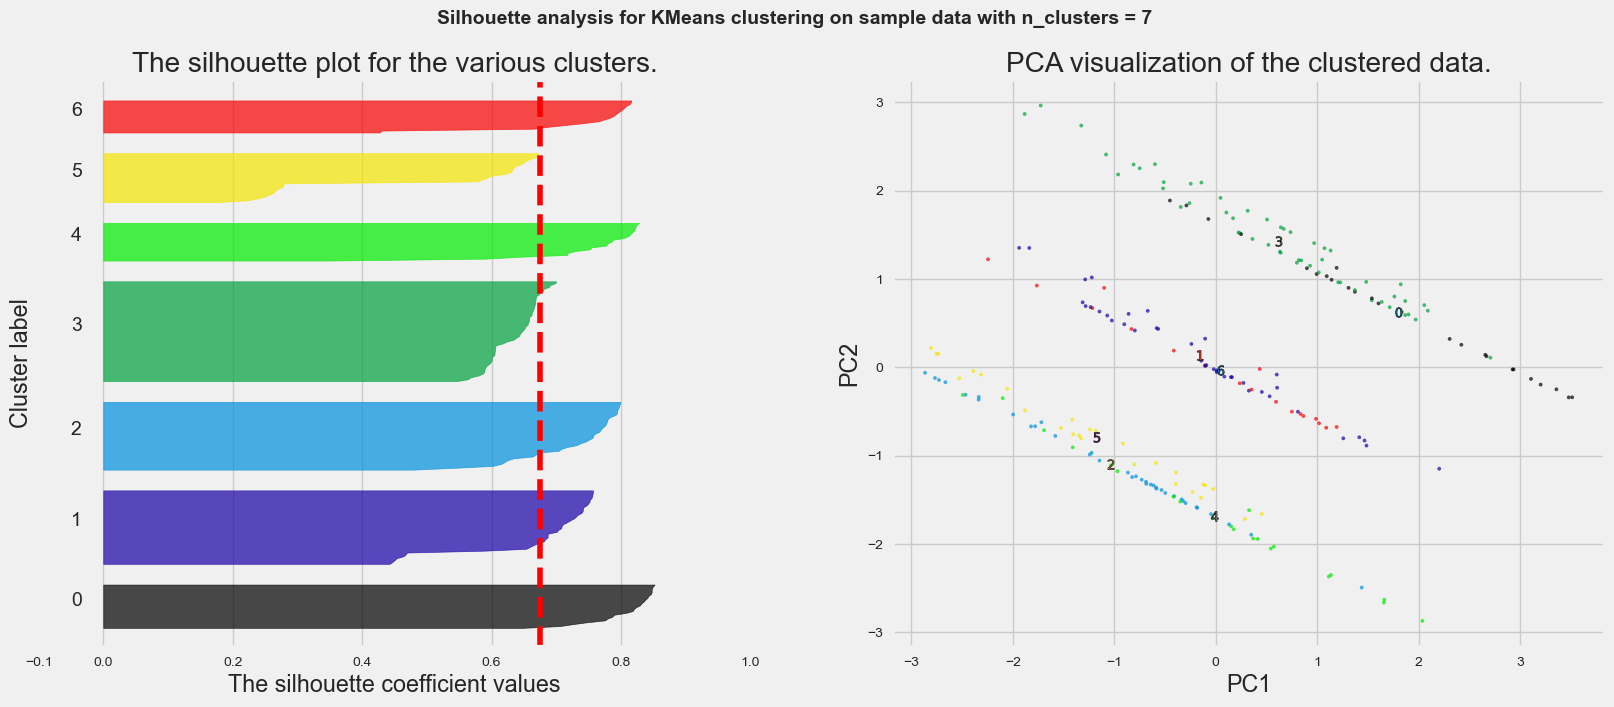

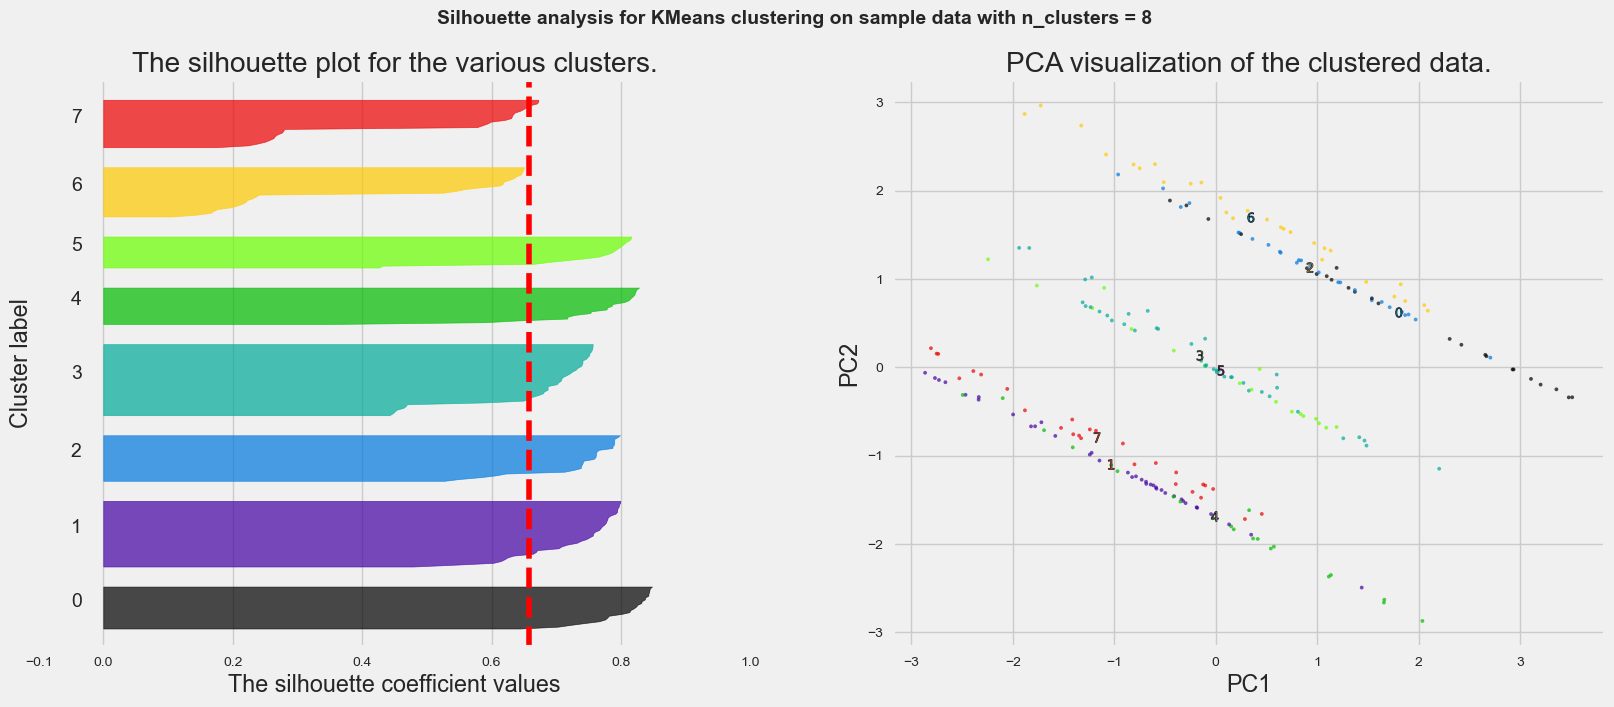

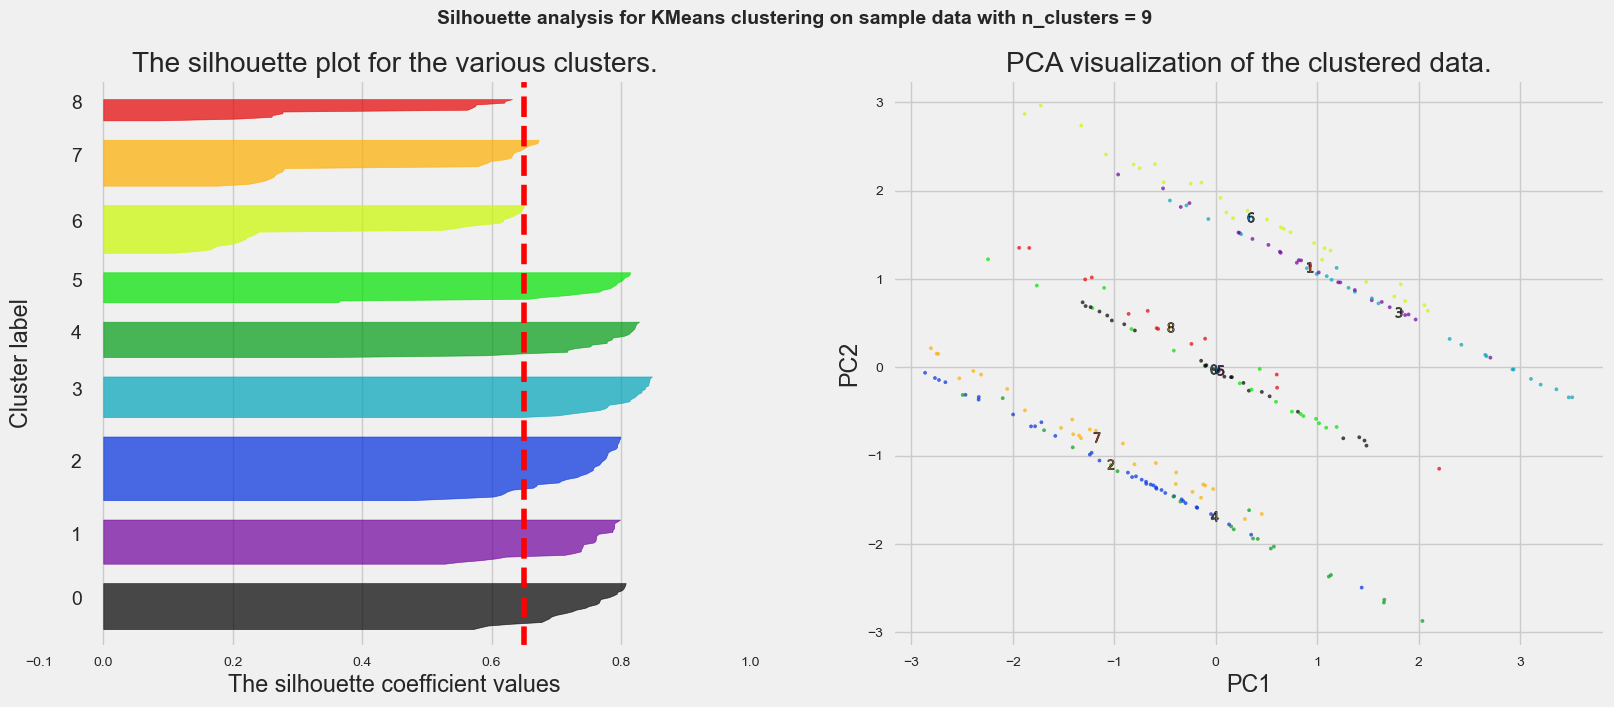

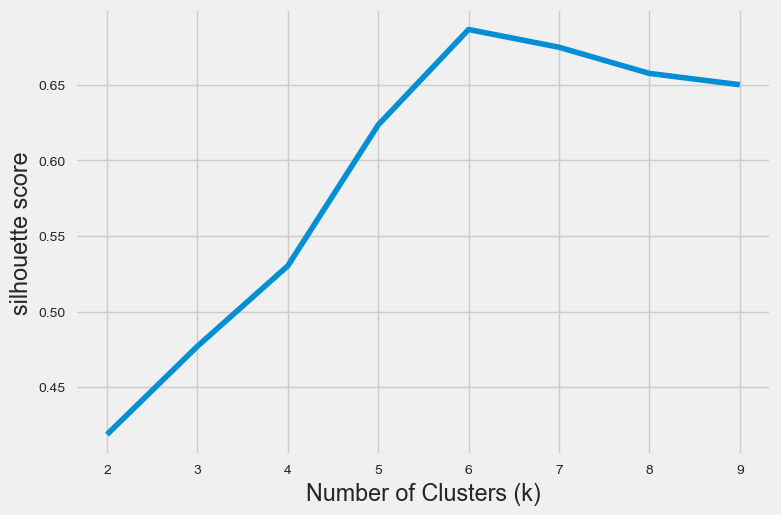

In [69]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.style as style

#X_ = X
X = df.to_numpy()

# Scale your data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2D scatter plot using PCA, showing the actual clusters formed
    #
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    #centers_pca = pca.transform(centers)
    centers_pca = np.zeros((n_clusters, 2))
    for i in range(n_clusters):
        centers_pca[i] = X_pca[cluster_labels == i].mean(axis=0)

    for i, c in enumerate(centers_pca):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
        #ax2.scatter(centers_pca[:, 0], centers_pca[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    ax2.set_title("PCA visualization of the clustered data.")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()

#### 3.3.1 Comment - Fingers Plot
We can see from above numeric results that $k = 6$ has the highest average silhouette score. Examining its fingers plot we can see that all 6 clusters are above the average score and all 6 fingers are fairly good consistency of thinkness so this is a good candidate for k means. 

## 3.4 Run k-Means Clustering

Based on both elbow diagram and silhouette below we can select number of clusters $k = 6$

In [70]:
k = 6

clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=1000).fit(df)
#print(clustered_data_sklearn)
#print(clustered_data_sklearn.cluster_centers_)
#print(clustered_data_sklearn.labels_)
#df.describe

### 3.4.1 Cluster Analysis

Compute statitics for attributes for each cluster and interpret the results in terms of the domain.

In [88]:
# Add the cluster labels as an extra column in the original dataframe
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)
#df.head()
df.groupby('cluster').mean()

Dependents  LoanAmount  Loan_Amount_Term  Credit_History  \
cluster                                                             
0          0.166667    0.446852              0.75             1.0   
1          0.223958    0.466054              0.75             1.0   
2          0.265432    0.438304              0.75             1.0   
3          0.013889    0.383999              0.75             1.0   
4          0.047619    0.413842              0.75             1.0   
5          0.074074    0.466890              0.75             1.0   

         Gender_Male  Married_Yes  Self_Employed_Yes  Education_Not Graduate  \
cluster                                                                        
0                1.0          1.0                0.0                     0.0   
1                1.0          1.0                0.0                     0.0   
2                1.0          1.0                0.0                     0.0   
3                1.0          0.0                0.0                     0.0   
4                1.0          0.0                0.0                     0.0   
5                1.0          0.0                0.0                     0.0   

         Property_Area_Semiurban  Property_Area_Urban  TotalIncome  
cluster                                                             
0                            0.0                  0.0     0.254243  
1                            1.0                  0.0     0.267575  
2                            0.0                  1.0     0.255313  
3                            0.0                  1.0     0.220161  
4                            1.0                  0.0     0.238683  
5                            0.0                  0.0     0.295953

In [87]:
df.groupby('cluster').sum()

Dependents  LoanAmount  Loan_Amount_Term  Credit_History  \
cluster                                                             
0          6.666667   17.874065             30.00              40   
1         14.333333   29.827441             48.00              64   
2         14.333333   23.668429             40.50              54   
3          0.333333    9.215978             18.00              24   
4          1.000000    8.690676             15.75              21   
5          1.333333    8.404025             13.50              18   

         Gender_Male  Married_Yes  Self_Employed_Yes  Education_Not Graduate  \
cluster                                                                        
0                 40           40                  0                       0   
1                 64           64                  0                       0   
2                 54           54                  0                       0   
3                 24            0                  0                       0   
4                 21            0                  0                       0   
5                 18            0                  0                       0   

         Property_Area_Semiurban  Property_Area_Urban  TotalIncome  
cluster                                                             
0                              0                    0    10.169709  
1                             64                    0    17.124780  
2                              0                   54    13.786919  
3                              0                   24     5.283860  
4                             21                    0     5.012338  
5                              0                    0     5.327163

### 3.4.2 Conclusion

By observing the tables above from the k-Means clusters we can identify a number of _personas_ that could be useful for example in a marketing campaigns to customers.

| Cluster ID| Label        | Description                                                                          |
|----       |----          |----                                                                                  |
| Cluster 0 | "Suburban Family Man" | Highest income, male, married, several childen, living in suburbs, good credit history, large long term loan (mortgage) |
| Cluster 1 | "Rural Family Man" | Middle income, male, married, 1-2 children, rural dweller, good credit history |
| Cluster 2 | "Urban Family Man" | Good income, male, married, several childen, urban dweller, smaller mortgage than "Suburban Family Man"|
| Cluster 3 | "Rural Single Female" | Lower income, female, single, rural dweller, no childen, no loan |
| Cluster 4 | "Urban Single Female" | Lower income, female, single, rural dweller, no childen, small loan, medium-term|
| Cluster 5 | "Suburban Single Female" | Lower income, female, single, rural dweller, no childen, small loan, short-term |


# Task 3: Other Clustering Techniques

## 4. Dimensionality Reduction
Above we have integrated a PCA to the Silhouette plot for visualation. Now we apply further MDS and t-SNE technique to project data and k-Means cluster centers to 2D space for plotting.

In [72]:
# Append the cluster centers to the dataset.
data = df.to_numpy()
data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]

### 4.1 MDS
Apply multi-dimensional scaling (MDS) to project data and k-Means cluster centers to a 2D space for plotting;

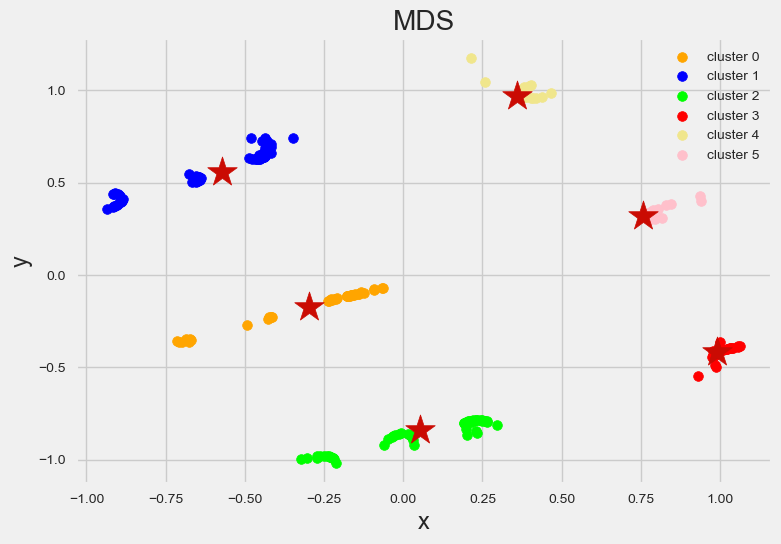

In [73]:
# Project the data and the k-Means cluster centers to 2D.
XYcoordinates = manifold.MDS(n_components=2, n_init=10, normalized_stress='auto').fit_transform(data_and_centers)
# Plot transformed examples and centers. Use cluster assignment to colour the examples.
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')
X_pca = XYcoordinates

#### 4.1.1 Try different distance metrics
##### 4.1.1.1 Cosine Distance


In [74]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

# Calculate pairwise distances using different metrics
dist_cosine = cosine_distances(data_and_centers)
dist_euclidean = euclidean_distances(data_and_centers)

# Fit MDS with different distances
n_components = 2
mds_cosine = MDS(n_components=n_components, dissimilarity='precomputed', normalized_stress='auto')
mds_euclidean = MDS(n_components=n_components, dissimilarity='precomputed', normalized_stress='auto')
X_mds_cosine = mds_cosine.fit_transform(dist_cosine)
X_mds_euclidean = mds_euclidean.fit_transform(dist_euclidean)

X_pca_cosine = mds_cosine

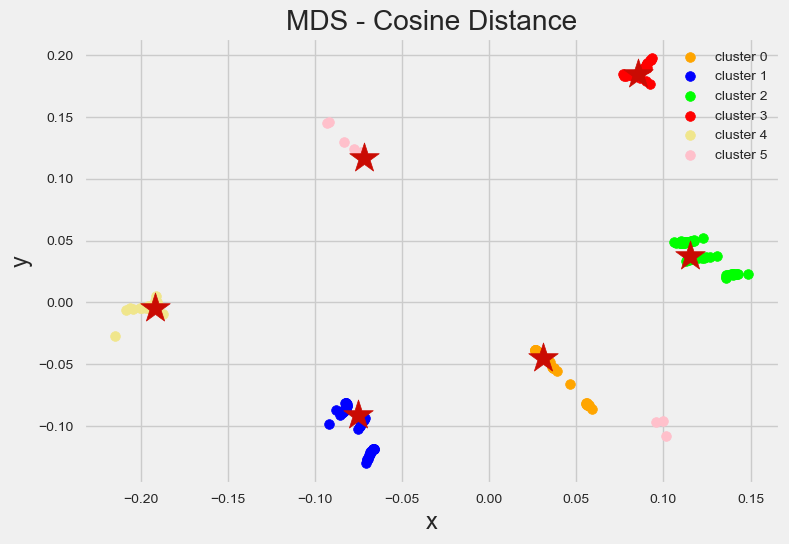

In [75]:
clustering_scatterplot(points=X_mds_cosine[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=X_mds_cosine[-k:,:], 
                       title='MDS - Cosine Distance')

The low-dimensional embeddings can be used as input to clustering algorithms to identify groups or clusters of similar data points. Clustering algorithms such as k-means or hierarchical clustering can be applied to the low-dimensional embeddings to partition the data into groups.

The low-dimensional embeddings can be used to visualize high-dimensional data in a more human-interpretable way. using visualization techniques such as scatterplots, heatmaps, or network graphs to explore the relationships between data points in the low-dimensional space.

### 4.2 t-SNE
Apply t-SNE to project both data and the k-Means cluster centers to a 2D space

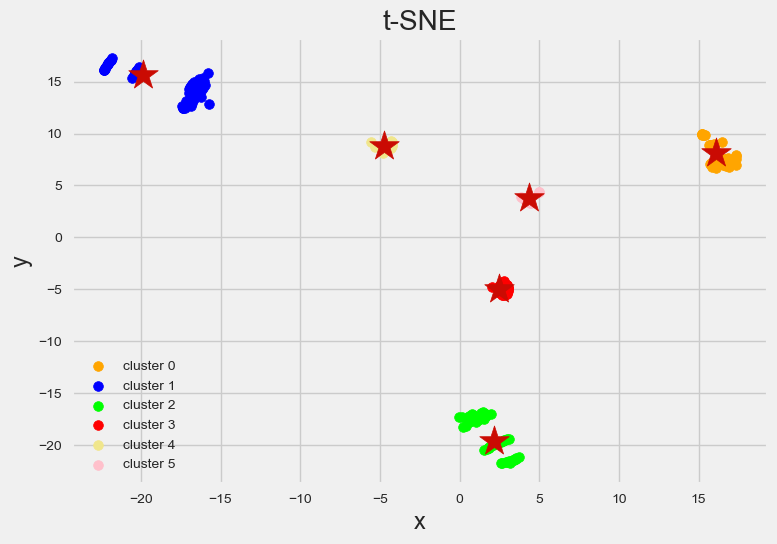

In [76]:
# Project both the data and the k-Means cluster centers to 2D.
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
# Plot  transformed examples and centers. Use cluster assignment to colour the examples.
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='t-SNE')
X_tsne = XYcoordinates

### 4.3 UMAP
UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique that can be used for visualization, as well as for general non-linear dimension reduction. UMAP is based on manifold learning techniques and topology, aiming to preserve both local and global structures in the data. UMAP is particularly useful for working with high-dimensional data, as it can effectively reduce dimensions while maintaining the relationships between data points. This makes it valuable for visualizing complex data structures and for pre-processing data before applying machine learning algorithms.

In [77]:
#data[:,-2]
#data_and_centers.shape
data_and_centers[:,0:-1]

array([[ 0.00000000e+00,  4.28771667e-01,  7.50000000e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 3.33333333e-01,  4.24365873e-01,  7.50000000e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  4.52186513e-01,  7.50000000e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.38888889e-02,  3.83999069e-01,  7.50000000e-01, ...,
         0.00000000e+00, -1.66533454e-16,  1.00000000e+00],
       [ 4.76190476e-02,  4.13841733e-01,  7.50000000e-01, ...,
         0.00000000e+00,  1.00000000e+00,  2.22044605e-16],
       [ 7.40740741e-02,  4.66890300e-01,  7.50000000e-01, ...,
         0.00000000e+00, -1.11022302e-16,  1.66533454e-16]])

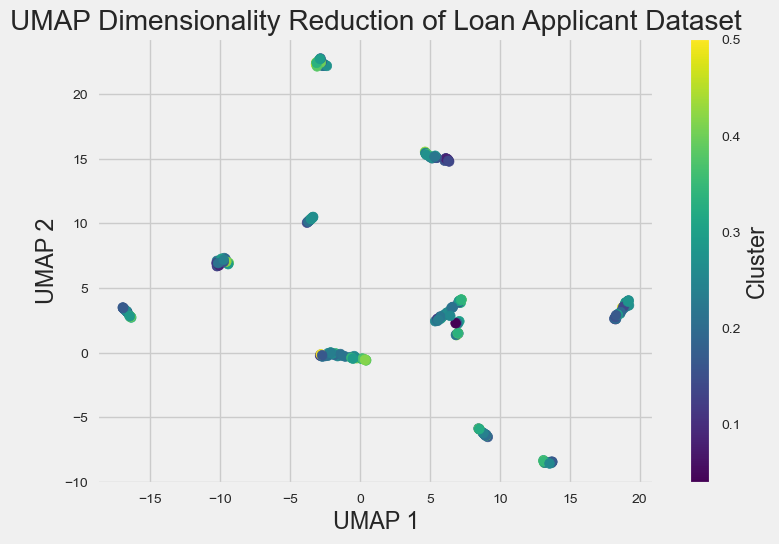

In [78]:
import umap

# Load the iris dataset
#data =
labels = data_and_centers[:,-1]  # Cluster, Loan_Status_Y -2

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP()
XYcoordinates = reducer.fit_transform(data_and_centers[:,0:-1])  # without cluster
X_umap = XYcoordinates

# Visualize the results
plt.scatter(XYcoordinates[:, 0], XYcoordinates[:, 1], c=labels, cmap='viridis')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Dimensionality Reduction of Loan Applicant Dataset')
plt.colorbar().set_label('Cluster')
plt.show()

### 4.4 Spectral Embedding

Also known as Spectral Clustering is a dimensionality reduction technique often used in machine learning and data visualization based on spectral graph theory, which studies properties of graphs using their eigenvalues and eigenvectors.

Idea is to  map the data points in a high-dimensional space to a lower-dimensional space while preserving the relationships between them. The technique works by constructing a graph from the data, where each data point is represented as a node and the edges between nodes represent the similarity or proximity between data points. The weights of the edges are typically calculated using a distance metric, such as the Euclidean distance, and a kernel function, like the Gaussian or heat kernel.

Spectral Embedding is particularly useful for clustering and visualization tasks, as it captures the inherent geometry of the data and can reveal hidden structures that are not apparent in the original high-dimensional space.

In [79]:
data_and_centers


array([[ 0.00000000e+00,  4.28771667e-01,  7.50000000e-01, ...,
         0.00000000e+00,  1.00000000e+00,  2.60946514e-01],
       [ 3.33333333e-01,  4.24365873e-01,  7.50000000e-01, ...,
         0.00000000e+00,  0.00000000e+00,  2.70511665e-01],
       [ 0.00000000e+00,  4.52186513e-01,  7.50000000e-01, ...,
         0.00000000e+00,  1.00000000e+00,  2.66949130e-01],
       ...,
       [ 1.38888889e-02,  3.83999069e-01,  7.50000000e-01, ...,
        -1.66533454e-16,  1.00000000e+00,  2.20160833e-01],
       [ 4.76190476e-02,  4.13841733e-01,  7.50000000e-01, ...,
         1.00000000e+00,  2.22044605e-16,  2.38682769e-01],
       [ 7.40740741e-02,  4.66890300e-01,  7.50000000e-01, ...,
        -1.11022302e-16,  1.66533454e-16,  2.95953482e-01]])

Unique data points in X_spectral: 218


/opt/anaconda3/envs/env-ul-course-data-analytics/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


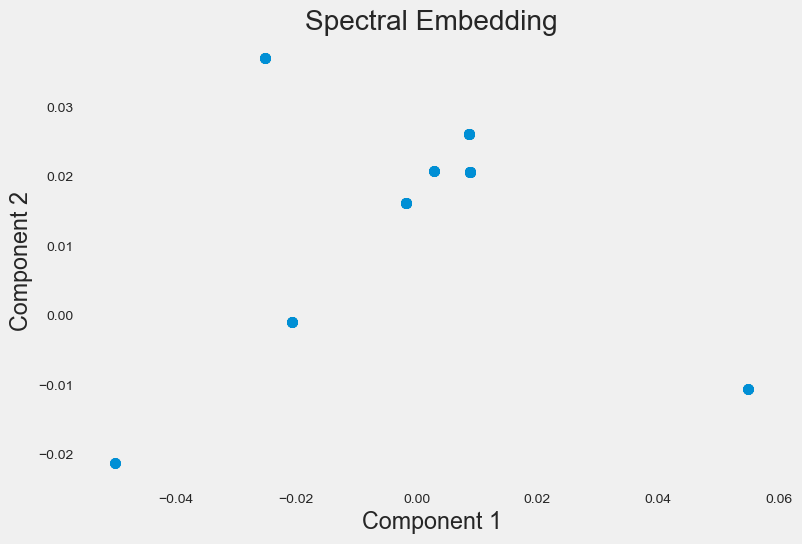

In [80]:
from sklearn.manifold import SpectralEmbedding

# Apply Spectral Embedding
embedding = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=10)
X_spectral = embedding.fit_transform(data_and_centers)
print("Unique data points in X_spectral:", len(np.unique(X_spectral, axis=0)))

# Plot the results
plt.scatter(X_spectral[:, 0], X_spectral[:, 1], s=50, alpha=0.5)
#plt.xlim(-0.01, 0.01)
#plt.ylim(-0.01, 0.01)
plt.title('Spectral Embedding')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid()
plt.show()


### 4.5 Comment - Dimensionality Reduction
The manifold techniques above including PCA, MDS and t-SNE plot all show dense, well-separated clusters for all 6 clusters in each case which is a indicator of good quality, distinct clusters.  This is a good basis for going forward with further clustering techniques...

## 5. Clustering Techniques

### 5.1 DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a popular clustering algorithm that groups points based on their density. Here we apply DBSCAN algorithm to the various 2D manifold-transformed data and plot resulting clusters for comparison. The different colors represent different clusters (black color indicates noise points);

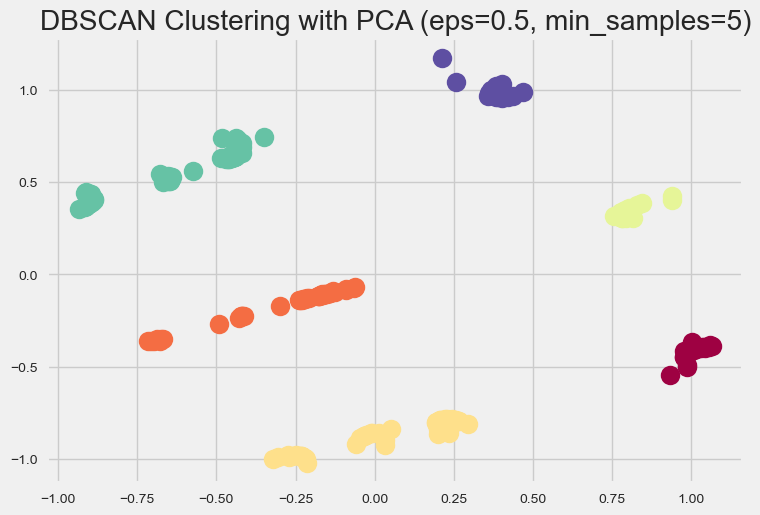

Calinski-Harabasz index: 858.3721562712128
Silhouette score: 0.7673599554944622


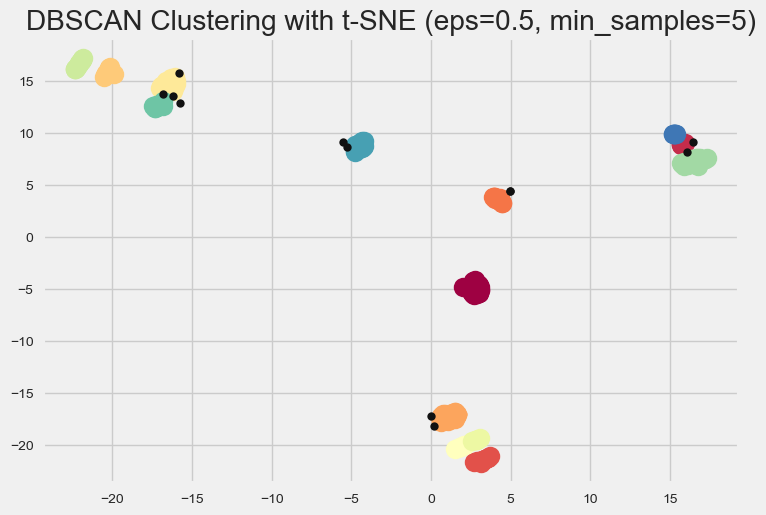

Calinski-Harabasz index: 351.25424682558474
Silhouette score: 0.6887482


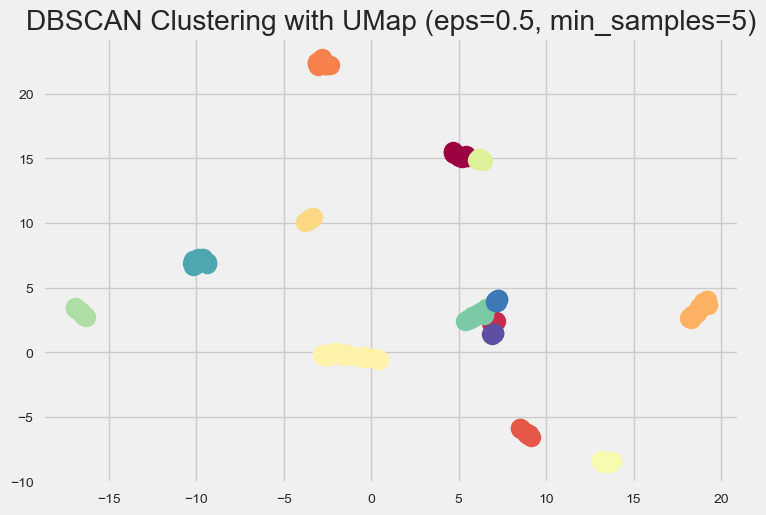

Calinski-Harabasz index: 8103.592658945144
Silhouette score: 0.8512715


In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import calinski_harabasz_score

def plot_dbscan(X_pca, title, eps=0.5, min_samples=5):
    # Apply DBSCAN algorithm
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X_pca)

    # Plot the results
    core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_samples_mask[dbscan.core_sample_indices_] = True

    unique_labels = set(clusters)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'k'  # Black for noise

        class_members_mask = (clusters == k)

        # Plot core samples
        xy = X_pca[class_members_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)

        # Plot non-core samples
        xy = X_pca[class_members_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)

    plt.title(f'DBSCAN Clustering with {title} (eps={eps}, min_samples={min_samples})'.format(eps, min_samples))
    plt.show()

    # Calculate Calinski-Harabasz index
    ch_score = calinski_harabasz_score(X_pca, clusters)
    print("Calinski-Harabasz index:", ch_score)

    # Calculate Silhouette score
    s_score = silhouette_score(X_pca, clusters)
    print("Silhouette score:", s_score)

plot_dbscan(X_pca, "PCA")
plot_dbscan(X_tsne, "t-SNE")
plot_dbscan(X_umap, "UMap")


#### 5.1.2 Comparing k-Means with DBSCAN

K-Means and DBSCAN are two popular clustering algorithms that differ in their approaches to grouping data points. K-Means works by minimizing the sum of squared distances between points and their assigned cluster centroids, whereas DBSCAN identifies regions of high density in the data space and assigns each point to a cluster based on proximity to other points in the same region.

K-Means is suitable for data with well-defined spherical clusters and when the number of clusters is known beforehand. It is computationally efficient and can scale well to large datasets. However, it can be sensitive to outliers and noise points, and requires careful initialization to avoid suboptimal solutions.

DBSCAN, on the other hand, is flexible and can handle data with arbitrary shapes and varying densities. It can automatically determine the number of clusters based on the density of data points and is more robust to noise and outliers than K-Means. However, it can be sensitive to the choice of its parameters, such as the minimum number of points required to form a dense region and the maximum distance between points in a dense region.

Choosing between the two algorithms depends on the specific characteristics of the data and the goals of the analysis. K-Means is a good choice when the data has well-defined spherical clusters and the number of clusters is known beforehand, while DBSCAN is more suitable for datasets with arbitrary shapes and varying densities. It is often recommended to try both algorithms and compare their results before making a final decision.

### 5.2 HDBSCAN

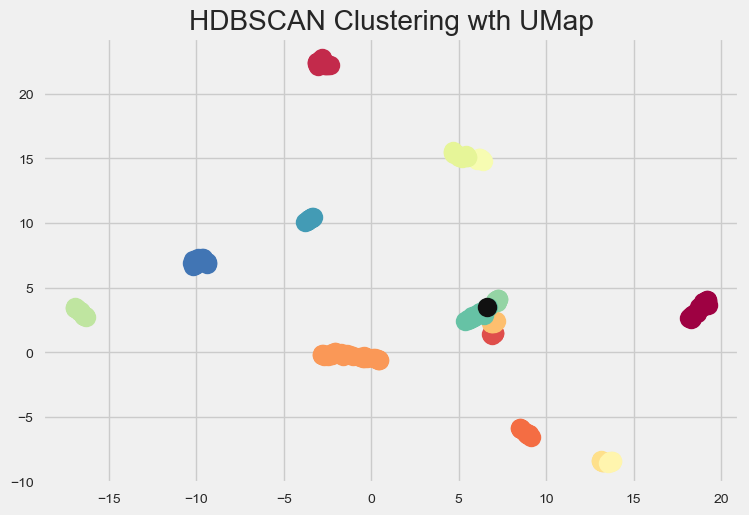

Calinski-Harabasz index: 7122.400756496747
Silhouette score: 0.8227957


In [95]:
import hdbscan

# Generate some sample data
X = X_umap #XYcoordinates

# Apply HDBSCAN algorithm
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
labels = clusterer.fit_predict(X)

# Plot the results
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(labels))))
for k, col in zip(set(labels), colors):
    if k == -1:
        col = 'k'  # Black for noise

    class_members = [index[0] for index in np.argwhere(labels == k)]
    xy = X[class_members]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)

plt.title('HDBSCAN Clustering wth UMap')
plt.show()

# Calculate Calinski-Harabasz index
ch_score = calinski_harabasz_score(X, labels)
print("Calinski-Harabasz index:", ch_score)

# Calculate Silhouette score
s_score = silhouette_score(X, labels)
print("Silhouette score:", s_score)


#### 5.2.1 Comparing HDBSCAN and DBSCAN
HDBSCAN is an extension of DBSCAN that adds a hierarchical clustering step, providing automatic determination of the number of clusters and robustness to parameter choices. However, it may be computationally expensive and may produce a large number of small clusters.

## 5.3 Hierarchichal (Agglomerative) 
Agglomerative clustering is a bottom-up approach that starts by treating each data point as a separate cluster, and then repeatedly merges the closest pair of clusters until only one cluster remains or a specific number of clusters is achieved.

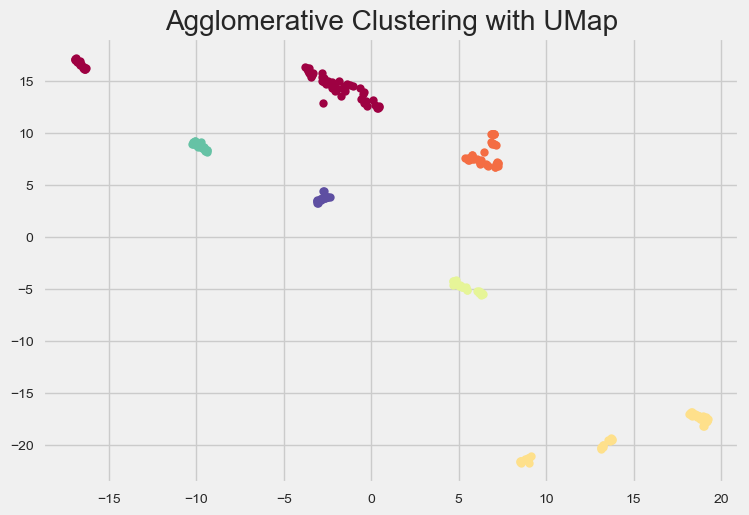

Calinski-Harabasz index: 200.97455768861724
Silhouette score: 0.5065981


In [99]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering
n_clusters = 6  # 4
agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
labels = agglomerative.fit_predict(X_tsne)

# Plot the results
colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))
for k, col in zip(range(n_clusters), colors):
    class_members = (labels == k)
    plt.plot(X_umap[class_members, 0], X_tsne[class_members, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)

plt.title('Agglomerative Clustering with UMap')
plt.show()

# Calculate Calinski-Harabasz index
ch_score = calinski_harabasz_score(X_umap, labels)
print("Calinski-Harabasz index:", ch_score)

# Calculate Silhouette score
s_score = silhouette_score(X_umap, labels)
print("Silhouette score:", s_score)

### 5.3.1 Comparing k-Means with Agglomerative
K-Means aims to minimize the sum of squared distances between data points and assigned cluster centroids iteratively. Agglomerative clustering, on the other hand, works by merging the two closest clusters in each iteration based on a distance metric until all data points are assigned to a single cluster. Unlike K-Means, Agglomerative clustering does not require the number of clusters to be specified beforehand and can result in a hierarchical clustering solution. However, Agglomerative clustering can be computationally expensive for large datasets, and the choice of distance metric and linkage criteria can significantly impact the resulting clusters.

## 5.4 Dendrogram
Allows us to observe how the clusters are formed at different levels of the hierarchy which helps us choose an appropriate number of clusters by examining the distance between branches. Applying the 'ward' method which minimizes the sum of squared differences within all clusters. We may also try other linkage methods, such as 'single', 'complete', and 'average', depending on data and requirements.

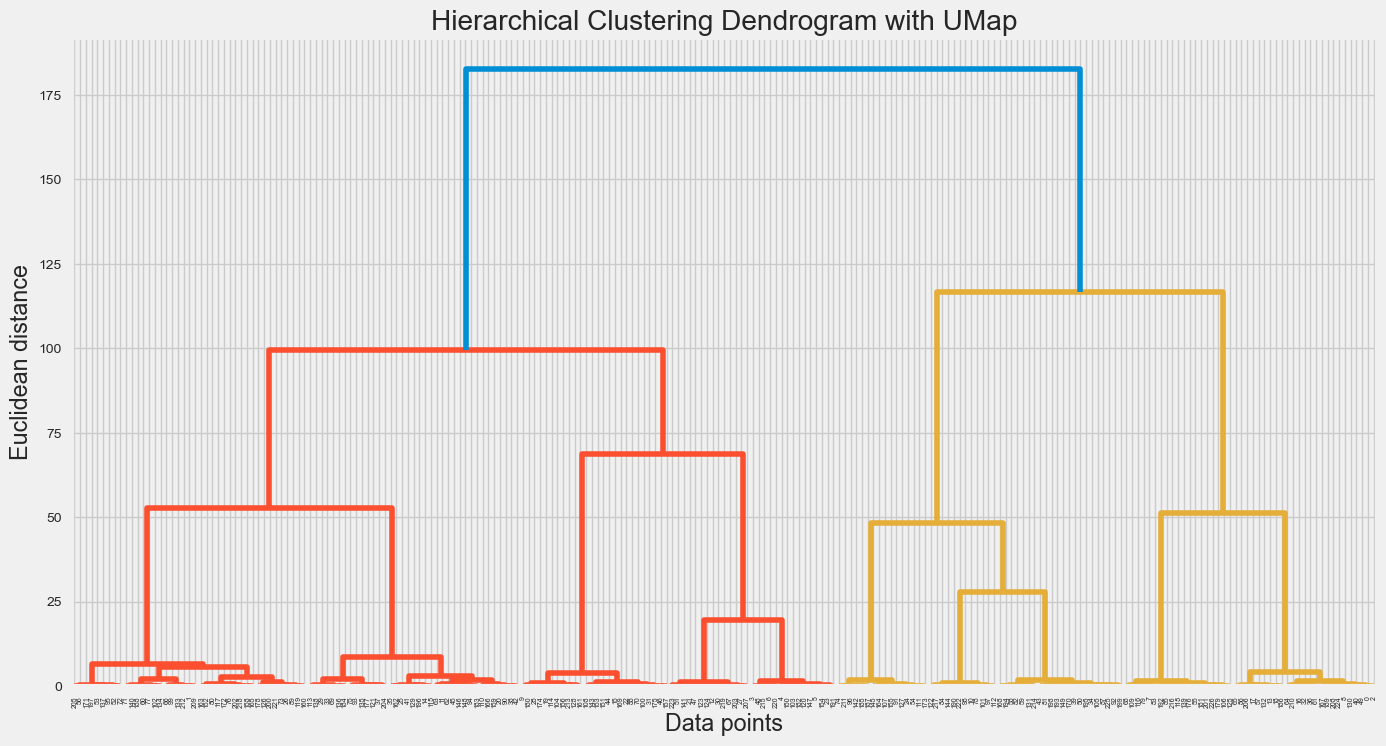

In [98]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform hierarchical clustering using the 'ward' method
Z = linkage(X_umap, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 8))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram with UMap')
plt.xlabel('Data points')
plt.ylabel('Euclidean distance')
plt.show()


### 5.3.1 Comparing k-Means and Dendrogram
The dendrogram shows the hierarchical relationships between clusters in agglomerative clustering, which works by merging the two closest clusters in each iteration based on a distance metric until all data points are assigned to a single cluster. Agglomerative clustering produces a dendrogram that can provide additional insight into the hierarchical relationships between clusters and can result in a hierarchical clustering solution. In contrast, K-Means clustering does not produce a dendrogram, as it is not a hierarchical clustering algorithm and assigns each data point to a single cluster based on the distance to the cluster centroid.

## Conclusion

From all of the above tests the best results in terms of metrics were from DBSCAN with UMap manifold transformation.
* Calinski-Harabasz index: 8103.592658945144
* Silhouette score: 0.8512715

However, even though it has lower scores, it is possible the the hierarchical clusters may be more interpretable, we would need to examine the cluster statistics and compare the story being told with those from k-Means.